# Fitting Overtones in GW150914: circular polarizations

We analyze the GW150914 ringdown using a more restrictive model than in `GW150914.ipynb` by assuming all modes are circularly polarized, corresponding to a face-off nonprecessing system. This is a special case of the "aligned" model, in which we assume the QNM initial conditions are symmetric under equatorial reflections (i.e., their excitation amplitudes satisfy $C_{\ell m n} = (-1)^\ell C_{\ell -m n}^*$), and thus the observed ellipticity of the modes depends only on the source inclination (see Appendix B in [Isi & Farr 2021](https://inspirehep.net/literature/1881773)).

Although this more closely resembles the analysis carried out in [Isi, et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019PhRvL.123k1102I/abstract), it is not meant to reproduce it exactly (e.g., it uses slightly different data, a different amplitude prior and an exponential parameterization of the Kerr deviations); the results are, nonetheless, consistent.

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [8]:
from pylab import *

import arviz as az
import h5py
import pandas as pd
import seaborn as sns

import ringdown

sns.set_context('notebook')
sns.set_palette('colorblind')

## Data

Let's download the data for GW150914, found [here](https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/).  We grab 32s of data in each IFO, sampled at 16 kHz.

In [9]:
#!wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5
#!wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5

If you grab the data, the MD5 sums should be:
```
MD5(H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5)= b345645c0488287301824fe617f58dc2
MD5(L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5)= 5eb246ff21364d38471c95452f012853
```

In [10]:
!openssl md5 H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5
!openssl md5 L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5

MD5(H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5)= b345645c0488287301824fe617f58dc2
MD5(L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5)= 5eb246ff21364d38471c95452f012853


Now we make timeseries data objects out of the stored data:

In [11]:
def read_strain(file, dname):
    with h5py.File(file, 'r') as f:
        t0 = f['meta/GPSstart'][()]
        T = f['meta/Duration'][()]
        h = f['strain/Strain'][:]
    
        dt = T/len(h)
    
        raw_strain = ringdown.Data(h, index=t0 + dt*arange(len(h)), ifo=dname)
        
        return raw_strain
    
h_raw_strain = read_strain('H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5', 'H1')
l_raw_strain = read_strain('L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5', 'L1')

Just a sanity-check plot of the raw strain (just look at the huuuuuge DC noise in LIGO):

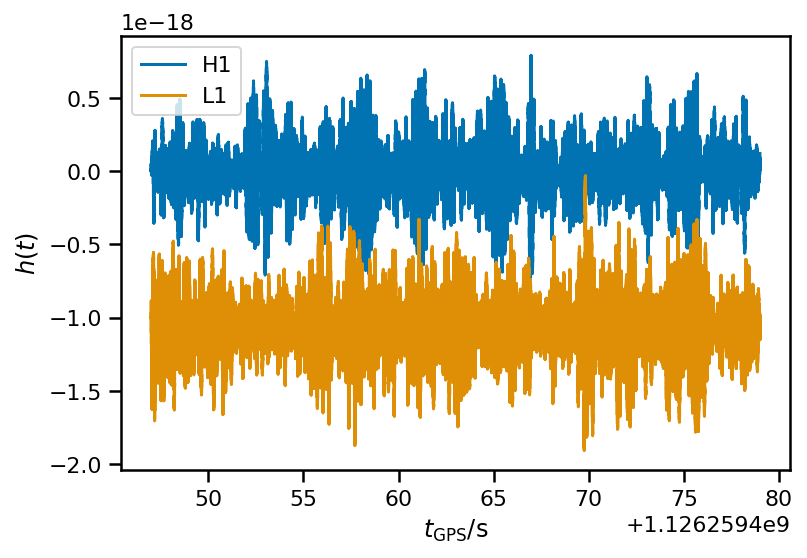

In [12]:
h_raw_strain.plot(label=h_raw_strain.ifo)
l_raw_strain.plot(label=l_raw_strain.ifo)
xlabel(r'$t_\mathrm{GPS} / \mathrm{s}$');
ylabel(r'$h(t)$');
legend(loc='best');

Now that we've got the strain loaded up, we want to condition it a bit.  LIGO does not have very good high-frequency sensitivity; also, our modes do not have a lot of high-frequency content.  Additionally, LIGO contains a lot of low-frequency noise and our templates do not have a lot of power at low frequencies.  Here are estimated noise PSDs for our data:

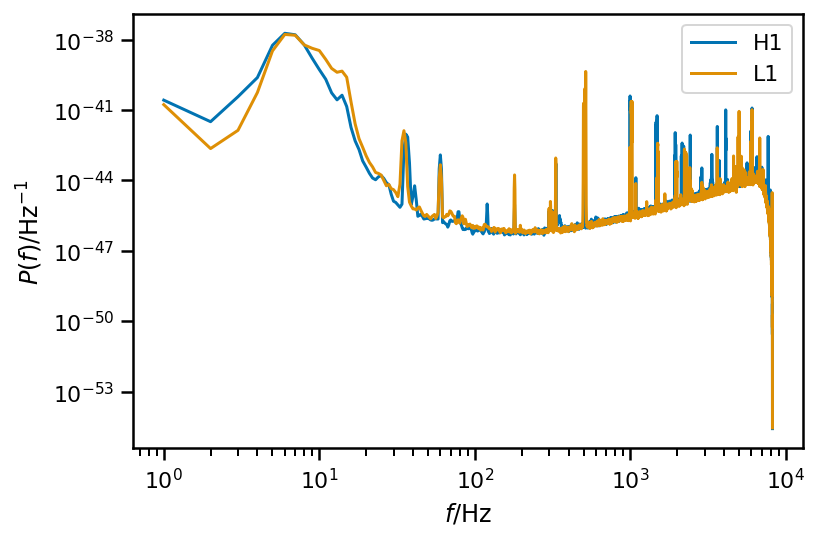

In [13]:
h_raw_strain.get_psd(nperseg=int(h_raw_strain.fsamp)).iloc[1:].plot(label=h_raw_strain.ifo)
l_raw_strain.get_psd(nperseg=int(l_raw_strain.fsamp)).iloc[1:].plot(label=l_raw_strain.ifo)
xlabel(r'$f / \mathrm{Hz}$');
ylabel(r'$P\left( f \right) / \mathrm{Hz}^{-1}$');
xscale('log');
yscale('log');
legend(loc='best');

Because the cost of our analysis scales as $N^2$ for a data segment of $N$ samples, and because the noise in LIGO combined with the finite bandwidth of ringdown modes means that the data are uninformative at both very low and very high frequencies, we can bandpass the data, downsample considerably (to eliminate high-frequency content), and truncate to a short data segment (to eliminate low frequency content)---rhe `condition_data` method below accomplishes this. We will downsample to a sample rate of 2048 Hz, and a segment length of $\sim 0.2\, \mathrm{s}$.  We choose this duration based on the impulse response of the noise whitening filter, which is of order $\sim 0.2\, \mathrm{s}$. (See `GW150914.ipynb` for further exposition.)

In [66]:
M_est = 68.5
chi_est = 0.69

longest_tau = ringdown.qnms.get_ftau(M_est, chi_est, 0, l=2, m=2)[1]
highest_drate = 1/ringdown.qnms.get_ftau(M_est, chi_est, 1, l=2, m=2)[1]
print('The damping rate of the second tone is: {:.1f} Hz'.format(highest_drate))
print('The time constant of the first tone is: {:.1f} ms'.format(1000*longest_tau))

def next_pow_two(x):
    y = 1
    while y < x:
        y = y << 1
    return y

T = 0.08
srate = 2048

print('Segment of {:.1f} ms at sample rate {:.0f}'.format(1000*T, srate))

The damping rate of the second tone is: 727.4 Hz
The time constant of the first tone is: 4.2 ms
Segment of 80.0 ms at sample rate 2048


When we downsample, we want to be sure to preserve a sample as close as possible to the ringdown "start time," corresponding to the arrival time of the peak of the complex strain of the (2,2) mode ([Giesler, et al. 2019](https://ui.adsabs.harvard.edu/abs/2019PhRvX...9d1060G/abstract)).  One issue we have to deal with is that the signal arrives in the detectors at different times (the time delay between detectors depends on the source location on the sky).  The `Fit` object knows how to handle this for us.  We take the sky location, polarization, and time of arrival from [Isi, et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019PhRvL.123k1102I/abstract), set the desired duration and sample rate, and call `condition_data`.  We high-pass filter the data with rollon at $20 \, \mathrm{Hz}$ to eliminate the large low-frequency noise present in the data.

The fit object expects to receive a list of modes to include in the fit; the most explicit way to specify them is to give tuples of `(p, s, l, m, n)`, where `p = +/- 1` indicates prograde/retrograde, `s = -2` is the spin weight, `l` and `m` are the usual angular quantum numbers, and `n` is the tone index.  (The modes are elliptically polarized, so there is no need to specify both + and - `m` quantum numbers; it is assumed that both positive and negative `m` contribute to a mode.)  Because Isi, et al. (2019) found only convincing evidence of two tones, that is the model we fit in this example.

Unlike in our other example, here we select the `mchi_aligned` model, which assumes the QNM excitations are symmetric under equatorial reflections, with observed ellipticity depending only on the cosine of the source inclination ($\cos \iota$).

Currently, this is only implemented for $\ell = |m| = 2$ modes: requesting a different angular harmonic will raise an error.
 The template is
$$
h_+ = \left(1+\cos^2\iota\right) \sum_n A_n e^{-t/\tau_n} \cos(\omega_n t - \phi_n)
$$
$$
h_\times = 2 \cos\iota \sum_n A_n e^{-t/\tau_n} \sin(\omega_n t - \phi_n)
$$

By construction, this is much more restrictive than our generic elliptical model (see Sec. II in [Isi & Farr 2021](https://inspirehep.net/literature/1881773)).

In [67]:
# M_est = 67
# chi_est = 0.69
# 5*t_unit
tinit=0.775

In [68]:
fit = ringdown.Fit(model='mchi_aligned', modes=[(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)])
fit.add_data(h_raw_strain)
fit.add_data(l_raw_strain)
t_unit=M_est*2950./2/299792458
ts_ins=0.125

fit.set_target(1126259462.4083147-ts_ins, ra=1.95, dec=-1.27, psi=0.82, duration=T+ts_ins)
fit.condition_data(ds=int(round(h_raw_strain.fsamp/srate)), flow=20)
# fit.filter_data(chi_est,M_est,0)
fit.set_target(1126259462.4083147+tinit*1e-3, ra=1.95, dec=-1.27, psi=0.82, duration=T)
fit.condition_data(ds=1, flow=20)

In [69]:
fit1 = ringdown.Fit(model='mchi_aligned', modes=[(1, -2, 2, 2, 0),(1, -2, 2, 2, 1)])
fit1.add_data(h_raw_strain)
fit1.add_data(l_raw_strain)

fit1.set_target(1126259462.4083147-ts_ins, ra=1.95, dec=-1.27, psi=0.82, duration=T+ts_ins)
fit1.condition_data(ds=int(round(h_raw_strain.fsamp/srate)), flow=20)
fit1.filter_data(chi_est,M_est,2,2,0)
fit1.set_target(1126259462.4083147+tinit*1e-3, ra=1.95, dec=-1.27, psi=0.82, duration=T)
fit1.condition_data(ds=1, flow=20)

In [70]:
fit2 = ringdown.Fit(model='mchi_aligned', modes=[(1, -2, 2, 2, 1)])
fit2.add_data(h_raw_strain)
fit2.add_data(l_raw_strain)

fit2.set_target(1126259462.4083147-ts_ins, ra=1.95, dec=-1.27, psi=0.82, duration=T+ts_ins)
fit2.condition_data(ds=int(round(h_raw_strain.fsamp/srate)), flow=20)
fit2.filter_data(chi_est,M_est,2,2,0)
fit2.set_target(1126259462.4083147+tinit*1e-3, ra=1.95, dec=-1.27, psi=0.82, duration=T)
fit2.condition_data(ds=1, flow=20)

In [71]:
fit3 = ringdown.Fit(model='mchi_aligned', modes=[(1, -2, 2, 2, 2)])
fit3.add_data(h_raw_strain)
fit3.add_data(l_raw_strain)

fit3.set_target(1126259462.4083147-ts_ins, ra=1.95, dec=-1.27, psi=0.82, duration=T+ts_ins)
fit3.condition_data(ds=int(round(h_raw_strain.fsamp/srate)), flow=20)
fit3.filter_data(chi_est,M_est,2,2,0)
fit3.filter_data(chi_est,M_est,2,2,1)
fit3.set_target(1126259462.4083147+tinit*1e-3, ra=1.95, dec=-1.27, psi=0.82, duration=T)
fit3.condition_data(ds=1, flow=20)

In [72]:
fit4 = ringdown.Fit(model='mchi_aligned', modes=[(1, -2, 2, 2, 0)])
fit4.add_data(h_raw_strain)
fit4.add_data(l_raw_strain)

fit4.set_target(1126259462.4083147-ts_ins, ra=1.95, dec=-1.27, psi=0.82, duration=T+ts_ins)
fit4.condition_data(ds=int(round(h_raw_strain.fsamp/srate)), flow=20)
fit4.filter_data(chi_est,M_est,2,2,1)
fit4.set_target(1126259462.4083147+tinit*1e-3, ra=1.95, dec=-1.27, psi=0.82, duration=T)
fit4.condition_data(ds=1, flow=20)

It is instructive to look at the whitened data segment in both interferometers:

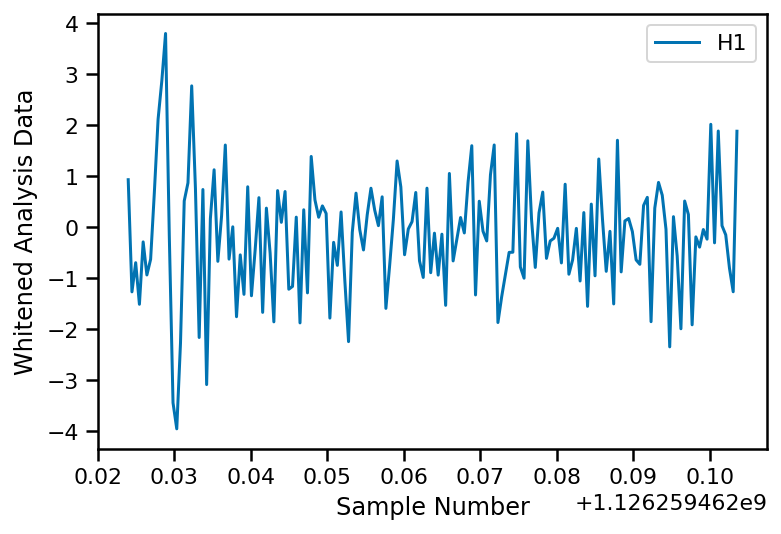

In [73]:
fit.compute_acfs()
wd = fit.whiten(fit.analysis_data)
plot(wd['H1'], label='H1')
# plot(wd['L1'], label='L1')
legend(loc='best');
xlabel(r'Sample Number');
ylabel(r'Whitened Analysis Data');

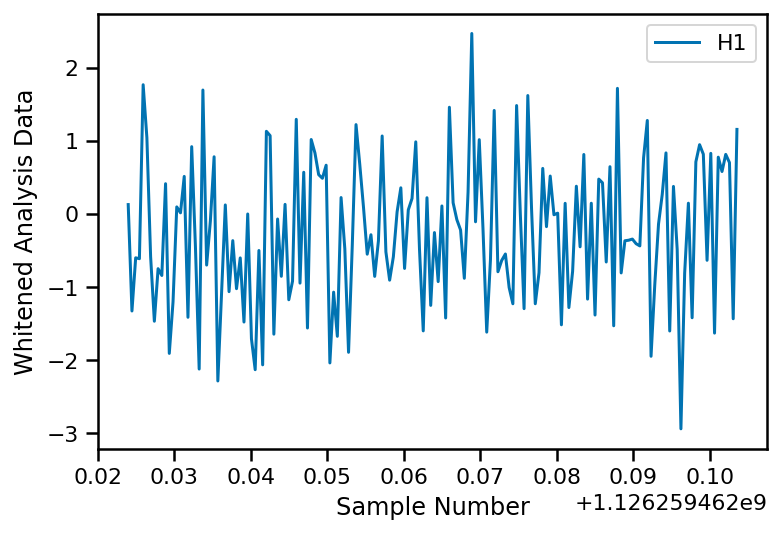

In [74]:
fit1.compute_acfs()
wd1 = fit1.whiten(fit1.analysis_data)
plot(wd1['H1'], label='H1')
# plot(wd['L1'], label='L1')
legend(loc='best');
xlabel(r'Sample Number');
ylabel(r'Whitened Analysis Data');

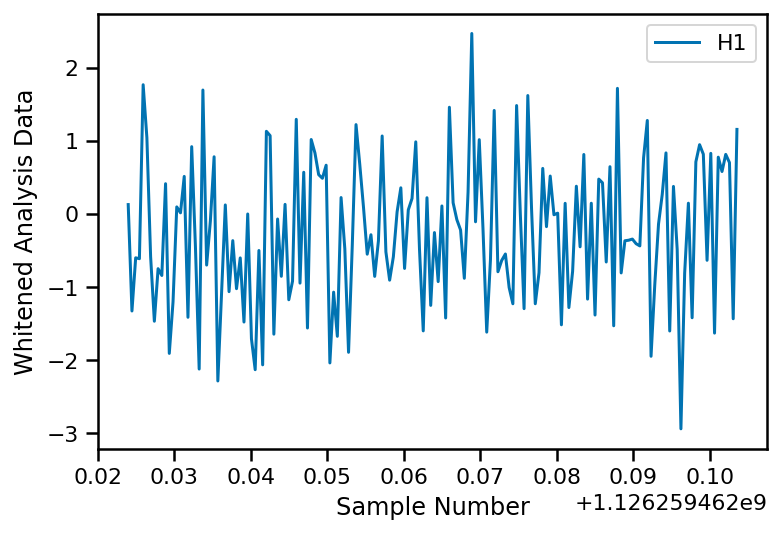

In [75]:
fit2.compute_acfs()
wd2 = fit2.whiten(fit2.analysis_data)
plot(wd2['H1'], label='H1')
# plot(wd['L1'], label='L1')
legend(loc='best');
xlabel(r'Sample Number');
ylabel(r'Whitened Analysis Data');

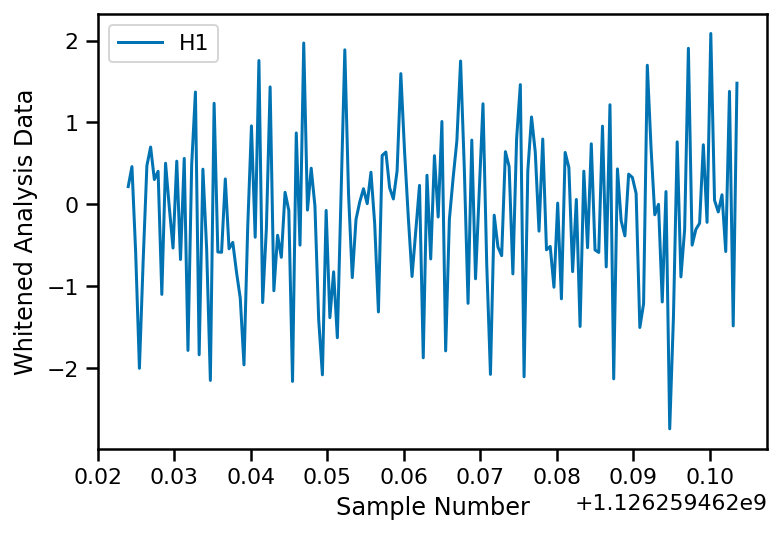

In [76]:
fit3.compute_acfs()
wd3 = fit3.whiten(fit3.analysis_data)
plot(wd3['H1'], label='H1')
# plot(wd['L1'], label='L1')
legend(loc='best');
xlabel(r'Sample Number');
ylabel(r'Whitened Analysis Data');

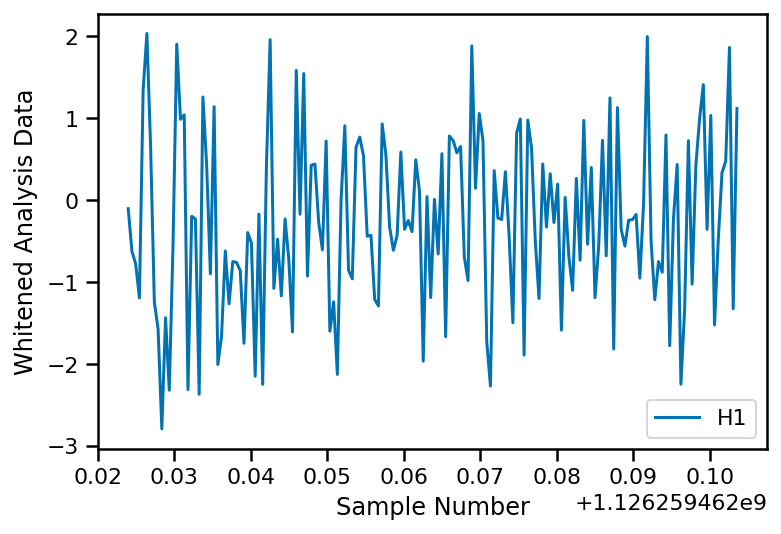

In [77]:
fit4.compute_acfs()
wd4 = fit4.whiten(fit4.analysis_data)
plot(wd4['H1'], label='H1')
# plot(wd['L1'], label='L1')
legend(loc='best');
xlabel(r'Sample Number');
ylabel(r'Whitened Analysis Data');

Just for a sanity check, let's look at the time of arrival of the peak strain in each IFO (Isi, et al. (2019) actually gives the `H1` start time, not the geocentre time, as `1126259462.423`):

In [78]:
fit.start_times

{'H1': 1126259462.4237752, 'L1': 1126259462.4167907}

In [79]:
fit1.start_times

{'H1': 1126259462.4237752, 'L1': 1126259462.4167907}

In [80]:
fit2.start_times

{'H1': 1126259462.4237752, 'L1': 1126259462.4167907}

In [81]:
fit3.start_times

{'H1': 1126259462.4237752, 'L1': 1126259462.4167907}

## Kerr fit

Before sampling over the posterior on modes, we need to set up some priors with reasonable choices:

In [82]:
print(fit.valid_model_options)

['A_scale', 'perturb_f', 'perturb_tau', 'df_max', 'dtau_max', 'M_min', 'M_max', 'chi_min', 'chi_max', 'cosi_min', 'cosi_max', 'flat_A']


The `flat_A` option controls whether we place a Gaussian prior on the quadratures (`flat_A = 0`, default)---which is much faster to sample because it does not have weird linear structures in the quadratures---or (as in our paper) a flat prior on `A` (`flat_A > 0`).  We set `A_scale = 5e-21`, which controls the scale of the Gaussian prior (`flat_A=0`) and also lets the sampler see approximately unit-scale variables (both prior choices).

Instead of an ellipticity parameter for each individual mode, the `mchi_aligned` model has a global inclination parameter `cosi` corresponding to the cosine of the source inclination. This parameter determines the ellipticity for _all_ modes, assuming the signal has an $\ell=|m|=2$ angular dependence and that the intrinsic mode excitations were symmetric under equatorial reflections ("nonprecessing" symmetry). By default, the prior is uniform in `-1 < cosi < 1`, but we will restrict that range by setting `cosi_max = -0.99`; this follows the expectation that the GW150914 was nearly face off.

In [83]:
fit.update_prior(A_scale=5e-21, M_min=35.0, M_max=140.0, cosi_max=-0.99, flat_A=True)

In [84]:
fit1.update_prior(A_scale=5e-21, M_min=35.0, M_max=140.0, cosi_max=-0.99, flat_A=True)

Here are the priors (with default values for the options we didn't set).  The `perturb` are boolean arrays indicating whether to perturb `f` and `tau` around the GR values; the perturbations (if present) are bounded to a maximum amplitude.

In [85]:
fit2.update_prior(A_scale=5e-21, M_min=35.0, M_max=140.0, cosi_max=-0.99, flat_A=True)

In [86]:
fit3.update_prior(A_scale=5e-21, M_min=35.0, M_max=140.0, cosi_max=-0.99, flat_A=True)

In [87]:
fit4.update_prior(A_scale=5e-21, M_min=35.0, M_max=140.0, cosi_max=-0.99, flat_A=True)

In [88]:
fit.prior_settings

{'A_scale': 5e-21,
 'perturb_f': array([0., 0.]),
 'perturb_tau': array([0., 0.]),
 'df_max': 0.5,
 'dtau_max': 0.5,
 'M_min': 35.0,
 'M_max': 140.0,
 'chi_min': 0,
 'chi_max': 0.99,
 'cosi_min': -1,
 'cosi_max': -0.99,
 'flat_A': True}

Our fit is ready to go; run it! **NOTE:** Since we picked $T = 0.2\, \mathrm{s}$ this might take a while---if you are in a hurry you can reduce that significantly (say, to $T = 0.05\, \mathrm{s}$ and still get a decent result.

(The `run()` method may take longer to execute the first time, as the model code is compiled and linked into the Python runtime.  Subsequent runs will use the precompiled code and be much quicker.)

In [89]:
fit.run()

In [90]:
fit1.run()

In [91]:
fit2.run()

In [92]:
fit3.run()

ERROR:pymc:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [93]:
fit4.run()

`fit.result` contains an arviz object giving our results:

In [94]:
az.summary(fit.result, var_names=['A', 'M', 'chi', 'f', 'tau'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A[0],0.000,0.000,0.000,0.000,0.000,0.000,755.0,1089.0,1.0
A[1],0.000,0.000,0.000,0.000,0.000,0.000,1184.0,1130.0,1.0
M,66.614,8.893,51.081,82.407,0.382,0.270,481.0,472.0,1.0
chi,0.554,0.206,0.145,0.907,0.012,0.008,340.0,193.0,1.0
f[0],240.277,10.806,217.254,258.711,0.416,0.294,772.0,485.0,1.0
f[1],232.640,11.890,209.733,253.390,0.563,0.398,510.0,498.0,1.0
tau[0],0.004,0.001,0.003,0.005,0.000,0.000,450.0,399.0,1.0
tau[1],0.001,0.000,0.001,0.002,0.000,0.000,441.0,380.0,1.0


In [95]:
az.summary(fit1.result, var_names=['A', 'M', 'chi', 'f', 'tau'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A[0],0.000,0.000,0.000,0.000,0.000,0.000,356.0,604.0,1.00
A[1],0.000,0.000,0.000,0.000,0.000,0.000,693.0,669.0,1.00
M,68.355,22.691,35.014,112.738,1.126,0.833,394.0,381.0,1.01
chi,0.410,0.255,0.002,0.830,0.008,0.006,832.0,822.0,1.00
f[0],235.778,65.698,113.161,365.221,3.160,2.239,426.0,446.0,1.00
f[1],225.998,63.718,106.088,349.654,3.026,2.141,438.0,489.0,1.00
tau[0],0.004,0.002,0.002,0.007,0.000,0.000,439.0,374.0,1.01
tau[1],0.001,0.001,0.001,0.002,0.000,0.000,446.0,395.0,1.01


In [96]:
az.summary(fit2.result, var_names=['A', 'M', 'chi', 'f', 'tau'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A[0],0.000,0.000,0.000,0.000,0.000,0.000,1191.0,1262.0,1.0
M,73.780,21.340,40.381,119.635,0.783,0.637,847.0,387.0,1.0
chi,0.463,0.255,0.028,0.874,0.007,0.005,1327.0,1064.0,1.0
f[0],211.887,51.215,108.857,302.568,1.658,1.173,951.0,636.0,1.0
tau[0],0.001,0.001,0.001,0.002,0.000,0.000,953.0,639.0,1.0


In [97]:
az.summary(fit3.result, var_names=['A', 'M', 'chi', 'f', 'tau'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A[0],0.000,0.000,0.000,0.000,0.000,0.000,180.0,38.0,1.01
M,85.651,31.526,39.101,137.097,1.853,1.507,248.0,939.0,1.01
chi,0.459,0.274,0.021,0.925,0.009,0.007,889.0,645.0,1.00
f[0],192.215,98.249,72.014,369.434,4.722,3.342,253.0,52.0,1.01
tau[0],0.001,0.000,0.000,0.002,0.000,0.000,588.0,973.0,1.00


In [98]:
az.summary(fit4.result, var_names=['A', 'M', 'chi', 'f', 'tau'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A[0],0.000,0.000,0.000,0.000,0.000,0.000,1135.0,1231.0,1.00
M,61.211,9.201,46.328,78.411,0.347,0.245,643.0,631.0,1.00
chi,0.474,0.229,0.035,0.846,0.010,0.007,450.0,314.0,1.01
f[0],250.141,12.130,226.260,272.978,0.301,0.214,1679.0,1358.0,1.00
tau[0],0.004,0.001,0.003,0.005,0.000,0.000,612.0,706.0,1.00


We can plot a trace, and see visually that the sampling seems OK:

In [99]:
# az.plot_trace(fit.result, var_names=['A', 'M', 'chi', 'f', 'tau'], compact=True);

In [100]:
# az.plot_trace(fit1.result, var_names=['A', 'M', 'chi', 'f', 'tau'], compact=True);

In [101]:
# az.plot_trace(fit2.result, var_names=['A', 'M', 'chi', 'f', 'tau'], compact=True);

In [102]:
# az.plot_trace(fit3.result, var_names=['A', 'M', 'chi', 'f', 'tau'], compact=True);

The total mass and spin that we recover are reasonable given the full waveform analysis of GW150914 (remember that the total mass will be the *detector frame* total mass!).  Note the use of `ringdown.kdeplot_2d_clevels` which draws contours at credible levels of the KDE estimate of the posterior distribution (here at 0.9, 0.5 and 0.1 credible levels).

In [103]:
# mIMR = M_est
# chiIMR = chi_est

# df = pd.DataFrame({
#     r'$M / M_\odot$': fit4.result.posterior.M.values.flatten(),
#     r'$\chi$': fit4.result.posterior.chi.values.flatten()
# })
# pg = sns.PairGrid(df, diag_sharey=False)
# pg.map_diag(sns.kdeplot);
# pg.map_upper(sns.scatterplot);
# pg.map_lower(ringdown.kdeplot_2d_clevels, levels=[0.9, 0.5, 0.1])

# pg.axes[0,0].axvline(mIMR, color='k')
# pg.axes[0,1].axvline(chiIMR, color='k')
# pg.axes[0,1].axhline(mIMR, color='k')
# pg.axes[1,0].axhline(chiIMR, color='k')
# pg.axes[1,0].axvline(mIMR, color='k')
# pg.axes[1,1].axvline(chiIMR, color='k')


In [104]:
# mIMR = M_est
# chiIMR = chi_est

# df = pd.DataFrame({
#     r'$M / M_\odot$': fit.result.posterior.M.values.flatten(),
#     r'$\chi$': fit.result.posterior.chi.values.flatten()
# })
# pg = sns.PairGrid(df, diag_sharey=False)
# pg.map_diag(sns.kdeplot);
# pg.map_upper(sns.scatterplot);
# pg.map_lower(ringdown.kdeplot_2d_clevels, levels=[0.9, 0.5, 0.1])

# pg.axes[0,0].axvline(mIMR, color='k')
# pg.axes[0,1].axvline(chiIMR, color='k')
# pg.axes[0,1].axhline(mIMR, color='k')
# pg.axes[1,0].axhline(chiIMR, color='k')
# pg.axes[1,0].axvline(mIMR, color='k')
# pg.axes[1,1].axvline(chiIMR, color='k')


In [105]:
# mIMR = M_est
# chiIMR = chi_est


# df = pd.DataFrame({
#     r'$M / M_\odot$': fit1.result.posterior.M.values.flatten(),
#     r'$\chi$': fit1.result.posterior.chi.values.flatten()
# })
# pg = sns.PairGrid(df, diag_sharey=False)
# pg.map_diag(sns.kdeplot);
# pg.map_upper(sns.scatterplot);
# pg.map_lower(ringdown.kdeplot_2d_clevels, levels=[0.9, 0.5, 0.1])

# pg.axes[0,0].axvline(mIMR, color='k')
# pg.axes[0,1].axvline(chiIMR, color='k')
# pg.axes[0,1].axhline(mIMR, color='k')
# pg.axes[1,0].axhline(chiIMR, color='k')
# pg.axes[1,0].axvline(mIMR, color='k')
# pg.axes[1,1].axvline(chiIMR, color='k')


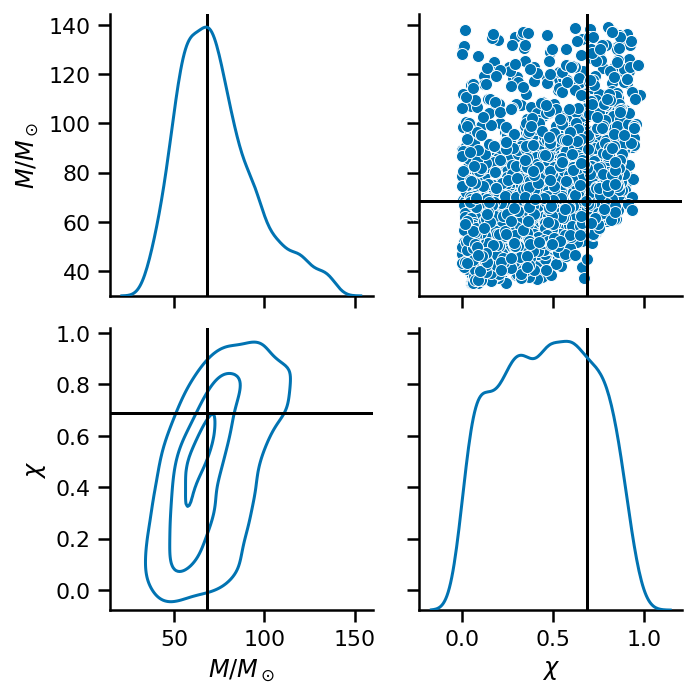

In [106]:
mIMR = M_est
chiIMR = chi_est


df = pd.DataFrame({
    r'$M / M_\odot$': fit2.result.posterior.M.values.flatten(),
    r'$\chi$': fit2.result.posterior.chi.values.flatten()
})
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot);
pg.map_upper(sns.scatterplot);
pg.map_lower(ringdown.kdeplot_2d_clevels, levels=[0.9, 0.5, 0.1])

pg.axes[0,0].axvline(mIMR, color='k')
pg.axes[0,1].axvline(chiIMR, color='k')
pg.axes[0,1].axhline(mIMR, color='k')
pg.axes[1,0].axhline(chiIMR, color='k')
pg.axes[1,0].axvline(mIMR, color='k')
pg.axes[1,1].axvline(chiIMR, color='k')


In [107]:
# mIMR = M_est
# chiIMR = chi_est


# df = pd.DataFrame({
#     r'$M / M_\odot$': fit3.result.posterior.M.values.flatten(),
#     r'$\chi$': fit3.result.posterior.chi.values.flatten()
# })
# pg = sns.PairGrid(df, diag_sharey=False)
# pg.map_diag(sns.kdeplot);
# pg.map_upper(sns.scatterplot);
# pg.map_lower(ringdown.kdeplot_2d_clevels, levels=[0.9, 0.5, 0.1])

# pg.axes[0,0].axvline(mIMR, color='k')
# pg.axes[0,1].axvline(chiIMR, color='k')
# pg.axes[0,1].axhline(mIMR, color='k')
# pg.axes[1,0].axhline(chiIMR, color='k')
# pg.axes[1,0].axvline(mIMR, color='k')
# pg.axes[1,1].axvline(chiIMR, color='k')


The fundamental mode is about $240 \, \mathrm{Hz}$; we measure its frequency to better than ~5%.

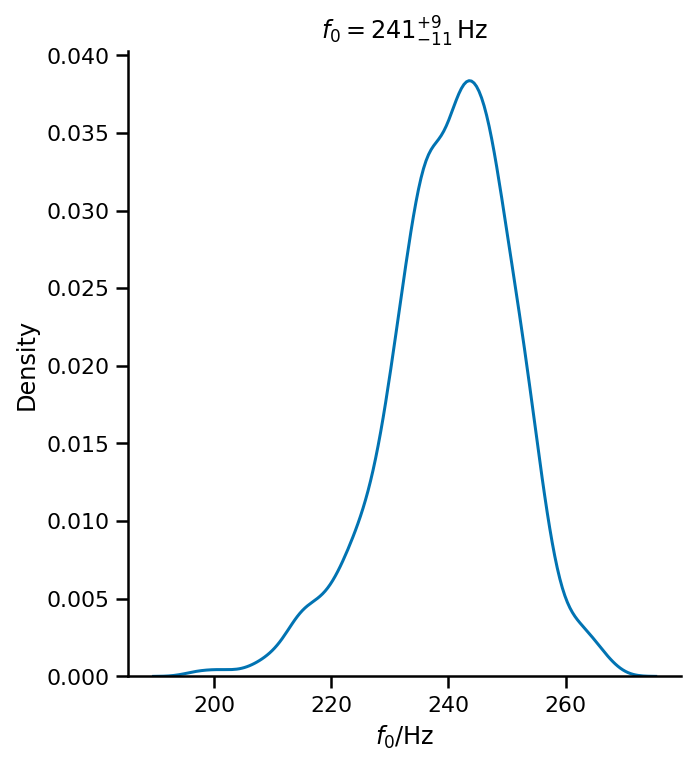

In [108]:
f0 = fit.result.posterior.f.values[:,:,0].flatten()
m = median(f0)
h = quantile(f0, 0.84)
l = quantile(f0, 0.16)
sns.displot(fit.result.posterior.f.values[:,:,0].flatten(), kind='kde')
xlabel(r'$f_0 / \mathrm{Hz}$');
title(r'$f_0 = {:.0f}^{{+{:.0f}}}_{{-{:.0f}}} \, \mathrm{{Hz}}$'.format(m, h-m, m-l));

Because of the Gaussian prior we have placed on the mode quadratures, the prior on the mode amplitudes is not flat (for small amplitude it goes as $A^3$ and then decays like a Gaussian at large amplitudes).  This is evident in the plot below.

It is interesting to look at the overtone amplitude:

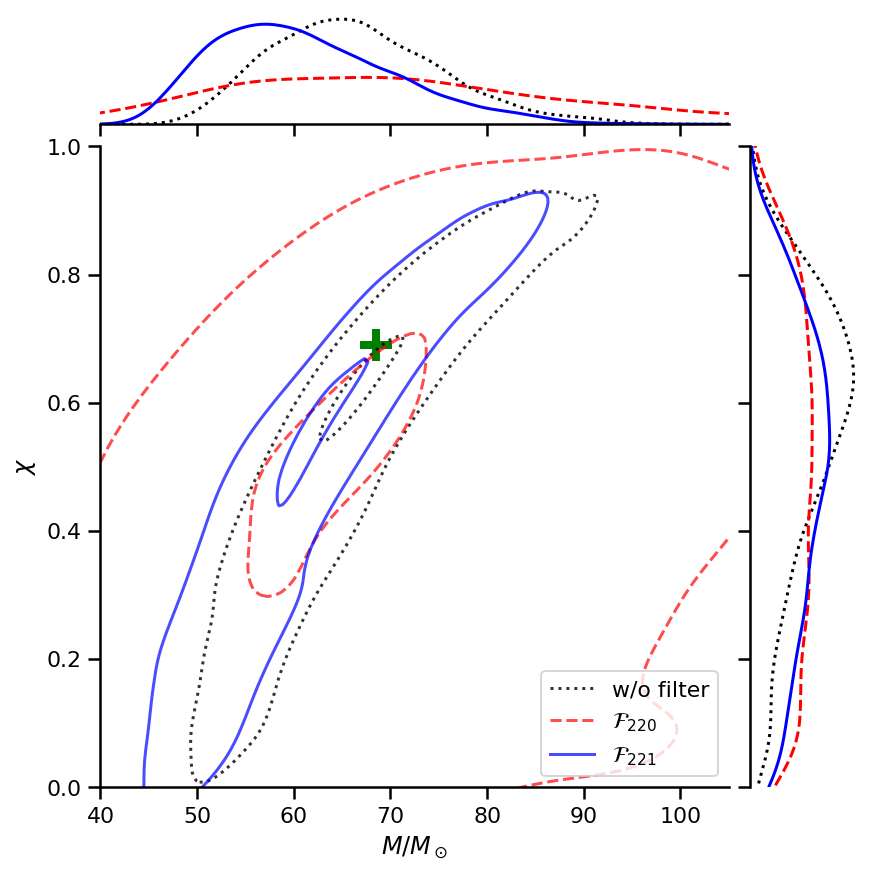

In [109]:
mIMR = M_est
chiIMR = chi_est

g = sns.JointGrid()

df = pd.DataFrame({
    r'$M / M_\odot$': fit.result.posterior.M.values.flatten(),
    r'$\chi$': fit.result.posterior.chi.values.flatten(),
    '1': 'w/o filter'
})
df2 = pd.DataFrame({
    r'$M / M_\odot$': fit2.result.posterior.M.values.flatten(),
    r'$\chi$': fit2.result.posterior.chi.values.flatten(),
    '1': r'$\mathcal{F}_{220}$'
})
df4 = pd.DataFrame({
    r'$M / M_\odot$': fit4.result.posterior.M.values.flatten(),
    r'$\chi$': fit4.result.posterior.chi.values.flatten(),
    '1': r'$\mathcal{F}_{221}$'
})
p=sns.kdeplot(data=df, x = r'$M / M_\odot$', y = r'$\chi$', levels=[0.1, 0.9],alpha=0.8, ax=g.ax_joint,hue='1', palette = ['k'],linestyles=':')
handles = p.legend_.legendHandles[::-1]
handles[0].set_ls(':')
handles[0].set_alpha(0.8)

p2=sns.kdeplot(data=df2, x = r'$M / M_\odot$', y = r'$\chi$', levels=[0.1, 0.9],alpha=0.7, ax=g.ax_joint,hue='1', palette = ['red'],linestyles='--')
handles2 = p2.legend_.legendHandles[::-1]
handles2[0].set_ls('--')
handles2[0].set_alpha(0.7)

p4=sns.kdeplot(data=df4, x = r'$M / M_\odot$', y = r'$\chi$', levels=[0.1, 0.9],alpha=0.7, ax=g.ax_joint,hue='1', palette = ['b'])
handles4 = p4.legend_.legendHandles[::-1]
handles4[0].set_alpha(0.7)

pscatter=g.ax_joint.scatter(x=68.5,y=0.69,s=255,marker='+',c='g',linewidths=4,label='IMR')
g.ax_joint.legend(loc='lower right',handles=handles+handles2+handles4,labels=['w/o filter',r'$\mathcal{F}_{220}$',r'$\mathcal{F}_{221}$'])


sns.kdeplot(df[r'$M / M_\odot$'], ax=g.ax_marg_x, color = 'k',linestyle=':')
sns.kdeplot(df2[r'$M / M_\odot$'], ax=g.ax_marg_x, linestyle="--", color = 'r')
sns.kdeplot(df4[r'$M / M_\odot$'], ax=g.ax_marg_x, color = 'b')
sns.kdeplot(y=df[r'$\chi$'], ax=g.ax_marg_y, color = 'k',linestyle=':')
sns.kdeplot(y=df2[r'$\chi$'], ax=g.ax_marg_y, linestyle="--", color = 'r')
sns.kdeplot(y=df4[r'$\chi$'], ax=g.ax_marg_y, color = 'b')
g.ax_joint.set_xlim(40,105)
g.ax_joint.set_ylim(0,1)
savefig('GW150914/mchi_ligo.pdf',bbox_inches='tight')

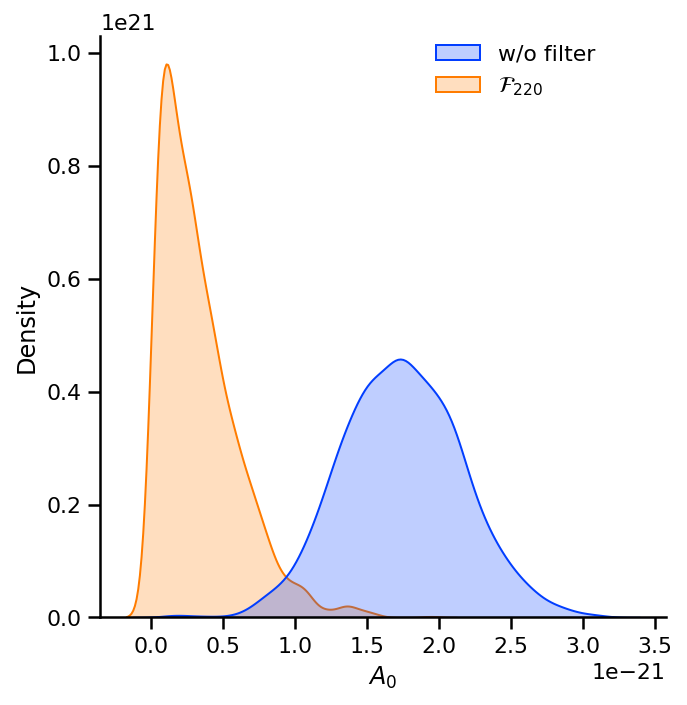

In [110]:
df=pd.DataFrame(data=np.c_[fit.result.posterior.A[:,:,0].values.flatten(),\
                           fit1.result.posterior.A[:,:,0].values.flatten()],
                    columns=[r'w/o filter',r'$\mathcal{F}_{220}$'])

g=sns.displot(df , kind="kde", fill=True, palette=sns.color_palette('bright')[:2])
xlabel(r'$A_0$')
sns.move_legend(g, "upper right", bbox_to_anchor=(.7, .95))
savefig('GW150914/A0.pdf',bbox_inches='tight')

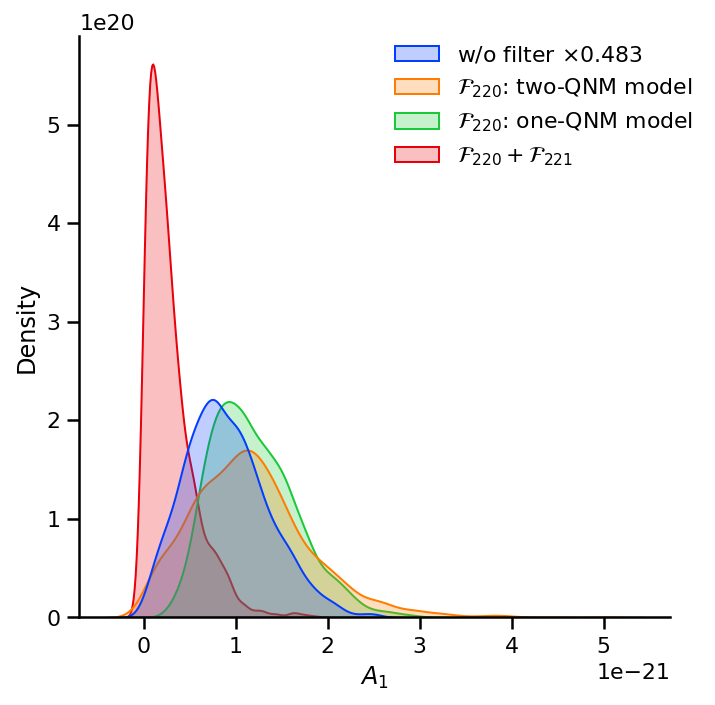

In [111]:
df=pd.DataFrame(data=np.c_[0.483*fit.result.posterior.A[:,:,1].values.flatten(),\
                           fit1.result.posterior.A[:,:,1].values.flatten(),\
                           fit2.result.posterior.A[:,:,0].values.flatten(),\
                            fit3.result.posterior.A.values[:,:,0].flatten()],
                    columns=[r'w/o filter $\times 0.483$',r'$\mathcal{F}_{220}$: two-QNM model',\
                            r'$\mathcal{F}_{220}$: one-QNM model', '$\mathcal{F}_{220}+\mathcal{F}_{221}$'])

g=sns.displot(df , kind="kde", fill=True, palette=sns.color_palette('bright')[:4])
xlabel(r'$A_1$')
sns.move_legend(g, "upper right", bbox_to_anchor=(.7, .95))
# legend(loc='center right')
savefig('GW150914/A1.pdf',bbox_inches='tight')

Get median signal reconstructions at each detector:

In [112]:
ms, mf, mo = {}, {}, {}

for i, ifo in enumerate(fit.ifos):
    # median reconstructed signal at each detector
    ms[ifo] = fit.result.posterior.h_det.median(axis=(0,1)).values[i,:] 

    # median reconstructed fundamental mode at each detector
    mf[ifo] = fit.result.posterior.h_det_mode.median(axis=(0,1)).values[i,0,:]

    # median reconstructed overtone at each detector
#     mo[ifo] = fit.result.posterior.h_det_mode.median(axis=(0,1)).values[i,1,:]

Here is a plot of the un-whitened (i.e. raw) ringdown signal, also decomposed into modes.

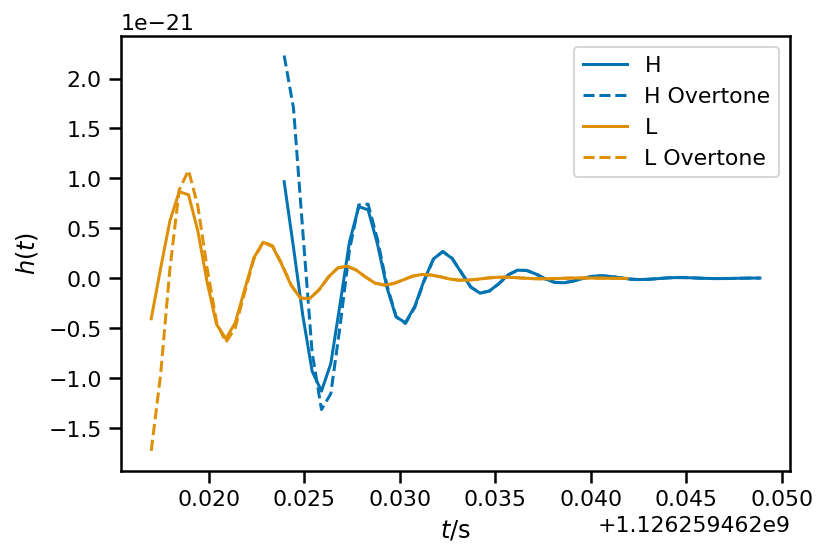

In [113]:
for ifo in fit.ifos:
    t = fit.analysis_data[ifo].time
    m = abs(t - t[0]) < 6*longest_tau
    l, = plot(t[m], ms[ifo][m], label=ifo[0])
    plot(t[m], mf[ifo][m], ls='--', color=l.get_color(), label=ifo[0]+' Overtone')
#     plot(t[m], mo[ifo][m], ls=':', color=l.get_color(), label=ifo[0]+' Overtone')

legend(loc='best');
xlabel(r'$t/\mathrm{s}$');
ylabel(r'$h(t)$');

In [114]:
import os
os.system('say "hi"')

0

# Reconstructions

In [229]:

# median reconstruction and 90%-credible envelope
wfs = [quantile(fit2.result.posterior.h_det.values, q, axis=(0,1))[0,:]
       for q in [0.5, 0.95, 0.05]]
wfs = [ringdown.Data(wf, index=fit.result.constant_data.times[0,:]) for wf in wfs]

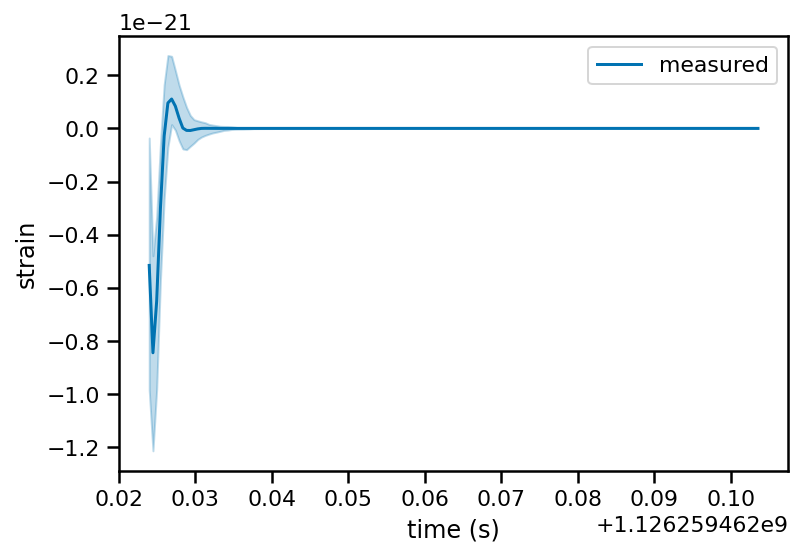

In [230]:

# plot reconstructions computed above
m, u, d = wfs
l, = plot(m, label='measured')
fill_between(m.time, u, d, color=l.get_color(), alpha=0.25)

# plot truth (using time mask to select right times)
# plot(signal_filter[m.time], c=l.get_color(), ls='--', label='truth')
# xlim(0,0.02)
xlabel('time (s)')
ylabel('strain')
legend();
# savefig('res/reconstruct_nr_injection_one_filter.pdf')

In [231]:
snrs_mf = fit2.compute_posterior_snrs(optimal=False)

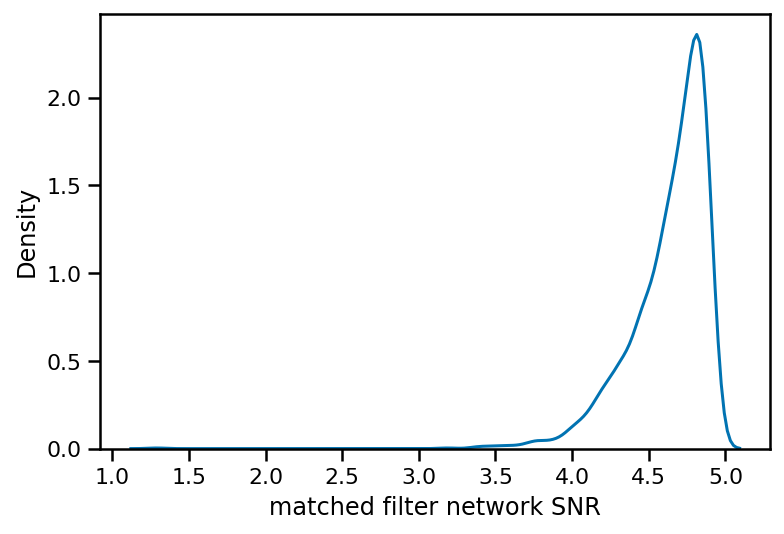

In [232]:
sns.kdeplot(snrs_mf)
xlabel('matched filter network SNR');
# savefig('res/snr_no_injection_one_filter.pdf')